# ADM-Homework 4 
    - Lohith Machani Sreenivasalu
    - Michele Cernigliaro
    - Paolo Gentile

# 1) Does basic house information reflect house's description?

In [8]:
import pandas as pd

### 1.a) Scraping the data

In this first point, we just created a function *scraping_function()* which scraps from www.immobiliare.it the information needed for this homework. The function will stop when the number of announcements reachs 10000. Informations will be stored into a dataframe, then, at the end, it will save the dataframe into a csv file, with path 'data/raw_data.csv'

In [1]:
import scraping as scr # our module scraping.py
#scr.scraping_function()

At the end, we obtain a dataframe with the following features:

In [4]:
df = pd.read_csv('data/raw_data.csv')
df.head()

,title,price,locali,superficie,bagni,piano,description
0,Nuovi Appartamenti e Attici / Mansarde in Vend...,€ 192.000 - € 705.000,1 - 5,46.0,NaN,NaN,\n Le residenze...
1,"Bilocale viale Italo Calvino, Fonte Ostiense, ...",€ 225.000,2,50.0,1,1 \n,\n PAPILLO EUR ...
2,"Quadrilocale via Alessandro Fleming, Fleming, ...",€ 1.350.000,4,200.0,2,2 \n,\n FLEMING - IN...
3,"Quadrilocale via Aosta 45, Re di Roma, Roma",€ 450.000,4,135.0,1,A \n,\n Rif: 18086 -...
4,"Attico / Mansarda largo Arturo Donaggio, Torre...",€ 135.000,2,60.0,1,5 \n,\n Torrevecchia...


### 1.b) Preprocess the data

Our task is to consider the following features:
    - price: price of the house
    - locali: number of rooms
    - superficie: surface of the house (squared meters)
    - bagni: number of bathrooms
    - piano: number of floor of the house
    
    - description: for the second part of the analysis
    
We can immediatly see that we need to preprocess our data. 

For example, for our analysis we are not able to consider NaN values. If we want to clusterize among these features, we have to drop announcements that don't provide all necessary information about them. Last but not least, we have to preprocess the description of each announcement, stemming the words.

Our criteria in the preprocessing is the following: 

1) **price**: we pick only numeric values. In the case that we have a range of values ( eg: € 192.000 - € 705.000) we pick the mean the average of the two. We drop out all the announcements withouth numerical values: for istance 'Prezzo su richiesta' ('price on request') and 'da € ---' ('from € ---'), because we are not able to establish which is the 'highest' price and so pick the average. We decided also to remove unsignificant prices for an house (less than 2 thousand euros)

2) **locali**: usually there's only one value. In case we have a range, for istance '1 - 5', we pick the last value.

3) **superficie**: this data doesn't need to be preprocessed, because it's already in float format. 

4) **piano**: piano can have different values. The largest values is 11+, which means the house is in a floor higher than 11. Since we don't know which is the value after 11th floor, instead of putting random values we decided drop off the announcements of which we don't know the floor value. For the others, we proceed in the following way:

+ 'T': ground floor, we replace it with 0
+ 'R': raized floor, we replace it with 0.5
+ 'A' or '11+': pentaus or more than 11: we replace it with NaN
+ 'R': basement, we replace it with -1


5) **description**: We stem the description ad place another column with stemmed string


To perform the preprocessing operations described above, we defined the following methods in a preprocess.py module

In [18]:
import preprocessing as prp # our library preprocessing.py

We use a functions from our library which picks raw data in input as dataframe ('data/raw_data.csv') and creates a new preprocessed dataframe in the path 'data/data_preprocessed'. 

In [19]:
# in data/data_preprocessed.csv
prp.preprocess_raw_data()

Our preprocessed dataframe is the following:

In [48]:
df = pd.read_csv('data/data_preprocessed.csv')
df.head()

,title,price,locali,superficie,bagni,piano,description,description_stemmed
0,"Bilocale viale Italo Calvino, Fonte Ostiense, ...",225000.0,2,50.0,1,1.0,\n PAPILLO EUR ...,papill eur in eleg compless residenzial rifini...
1,"Quadrilocale via Alessandro Fleming, Fleming, ...",1350000.0,4,200.0,2,2.0,\n FLEMING - IN...,fleming in strad priv via alessandr fleming si...
2,"Attico / Mansarda largo Arturo Donaggio, Torre...",135000.0,2,60.0,1,5.0,\n Torrevecchia...,torrevecc adiacent larg artur donagg appart in...
3,"Bilocale viale delle Medaglie d'Oro 124, Medag...",249000.0,2,75.0,1,1.0,"\n Balduina, ad...",balduin adiacent piazz giovenal appart in vend...
4,"Bilocale via Savona, Villa Fiorelli, Roma",339000.0,2,70.0,1,3.0,\n In Via Savon...,in via savon una strad tranquill nel cuor di s...


Now we can proceed with the other task of the homeworks

### 1.c) Make two matrices

#### a) Matrix with price, locali, superficie, bagni, piano

This matrix it's almost done. The only thing that we have to do is to load it from our original dataframe using only the columns needed. Each row of the dataframe is relative ad an announcement.

In [55]:
df_features = pd.read_csv('data/data_preprocessed.csv', usecols=['price', 'locali', 'superficie', 'bagni', 'piano'])
df_features.head()

,price,locali,superficie,bagni,piano
0,225000.0,2,50.0,1,1.0
1,1350000.0,4,200.0,2,2.0
2,135000.0,2,60.0,1,5.0
3,249000.0,2,75.0,1,1.0
4,339000.0,2,70.0,1,3.0


#### b) TFIDF matrix from the description

For this task we need to compute the ${ TFIDF }$ matrix. We will have ${TF_{i,j} \times IDF_j}$, where:

$$TF_{i,j} = \frac{n_{i,j}}{\mid a_i \mid}$$

With $n_{i,j}$ number of times word j appears in announcement i, and $\mid a_i \mid$ cardinality of announcement i.

$$IDF_j = \log \frac{n}{\mid a_j \mid}$$

With n the number of documents and $a_j$ the number of documents which contain the word j


We implemented the TFIDF using *numpy* arrays, and *Counter* dictionaries from *collection* lib. But before implementing it we created a vocabulary which will transform words in words_ID. The functions are in the module *matrix_generator*.
The vocabulary will be stored in the dataframe.

In [50]:
import matrix_generator as mtrx # our module matrix_generator.py

In [51]:
# making the vocabulary
mtrx.make_vocabulary(df)

In [52]:
# we use the function load_object to show the len of the vocabulary
len(mtrx.load_obj('vocabulary'))

20850

As you can see, we obtained a dictionary with 20850 words! Now, using the vocabulary, we can create a TFIDF matrix, with the announcements in the rows and words as features (columns)

In [53]:
TFIDF_matrix = mtrx.make_TFIDF(df=df)

In [54]:
TFIDF_matrix

array([[0.04466942, 0.01546518, 0.09826028, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00630063, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.07813101],
       [0.01245711, 0.00431283, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01515894, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [36]:
# putting TFIDF_matrix into a dataframe
TFIDF_dataframe = pd.DataFrame(TFIDF_matrix)
TFIDF_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,20840,20841,20842,20843,20844,20845,20846,20847,20848,20849
0,0.062615,0.010620,0.029324,0.011077,0.011151,0.068965,0.024561,0.041866,0.003965,0.036251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.009025,0.000000,0.000000,0.010006,0.000000,0.003231,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.005364,0.000000,0.005595,0.028161,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice that the features (columns) are the word_ID for each word founded in all the document.

## 1.d) K-Means

Now that we have the 2 matrices we can start with our k-means analysis. We will start from the first matrix

### K-Means with 5 features: price, locali, superficie, bagni, piano

We already have the matrix, the only thing that we need to do now is to prepare the data before using **The Elbow method**. Since each feature has different units of measurement, we need first of all to 'normalize' the values. To do this we use a function in sklearn called MinMaxScaler, that will give to each feature a new domain [0,1].

In [73]:
import k_means as km

In [74]:
data_transformed = km.transform_data(df_features)
data_transformed

array([[-0.47922807, -1.14912341, -1.00337296, -0.8764586 , -0.63539358],
       [ 2.5666562 ,  0.65982715,  1.69442209,  0.6468215 , -0.10243393],
       [-0.72289881, -1.14912341, -0.82351996, -0.8764586 ,  1.49644499],
       ...,
       [ 0.94218459,  1.56430244,  3.67280513,  2.17010159,  0.43052571],
       [-0.30324364, -0.24464813, -0.37388745,  0.6468215 , -0.63539358],
       [-0.60377089, -0.24464813, -0.28396095, -0.8764586 , -0.9018734 ]])

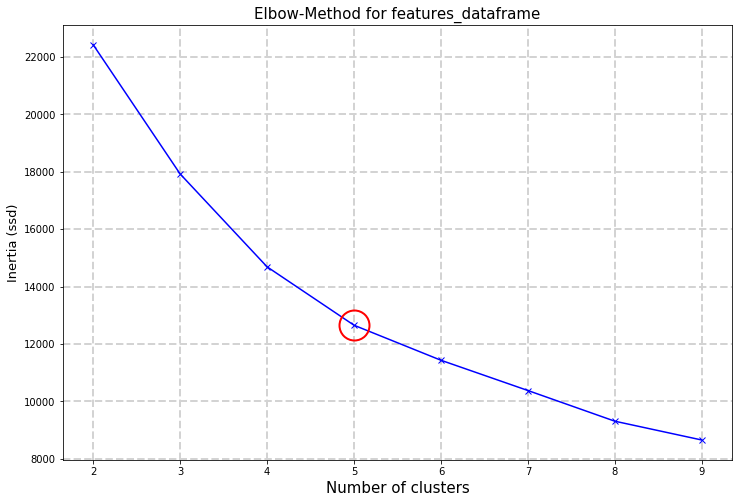

In [258]:
km.elbow_method(pd.DataFrame(data_transformed), max_clusters=10)

As we can see, from the elbow method the suggestion is to compute the k-means with 5 clusters, where there's a significant change in slope of the 'sum of distances' line. So, at this point we decide to pick 8 clusters, and we can start to execute k-means algorithm. We use the KMeans++ from sklearn module, and then we attach the result on our initial preprocessed dataframe *df*.

In [75]:
from sklearn.cluster import KMeans

# kmeans++ with seed 1234 (for reproducibility). 
model = KMeans(n_clusters=5, random_state=1234, init='k-means++')
model.fit(data_transformed)
clusters = model.predict(data_transformed)
df['features_cluster'] = clusters
df.head()

,title,price,locali,superficie,bagni,piano,description,description_stemmed,features_cluster
0,"Bilocale viale Italo Calvino, Fonte Ostiense, ...",225000.0,2,50.0,1,1.0,\n PAPILLO EUR ...,papill eur in eleg compless residenzial rifini...,0
1,"Quadrilocale via Alessandro Fleming, Fleming, ...",1350000.0,4,200.0,2,2.0,\n FLEMING - IN...,fleming in strad priv via alessandr fleming si...,2
2,"Attico / Mansarda largo Arturo Donaggio, Torre...",135000.0,2,60.0,1,5.0,\n Torrevecchia...,torrevecc adiacent larg artur donagg appart in...,4
3,"Bilocale viale delle Medaglie d'Oro 124, Medag...",249000.0,2,75.0,1,1.0,"\n Balduina, ad...",balduin adiacent piazz giovenal appart in vend...,0
4,"Bilocale via Savona, Villa Fiorelli, Roma",339000.0,2,70.0,1,3.0,\n In Via Savon...,in via savon una strad tranquill nel cuor di s...,0


Now for each announcement we have another cluster attribute, **features_cluster**. This feature indicates the cluster to which each announcement belongs. If we want to see the number of announcements contained in each cluster we can simply groupby *features_cluster*

In [150]:
df.groupby('features_cluster').price.count()

features_cluster
0    2605
1    1351
2     295
3    1757
4    1375
Name: price, dtype: int64

We notice that we have a cluster (the 6th,  so the '5' in order of index), that has significantly less values than the others. Maybe there's a strict relation between the announcements or maybe they are outliers.

### K-Means with 5 TFIDF




In [213]:
reload(km)

<module 'k_means' from '/Users/miguel/Desktop/ADM_HW4/ADM-HW4/k_means.py'>

To implement K-Means, we have to choose the number of clusters. For this task, we faced out a computational and a logical problem. Is it logic to implement K-means over more than 20000 features? Surely we will have a lot of 'outliers', for example, features, or actually words, that recurs only in few documents. 

We decided to compute the occurency of each word in the dictionary:

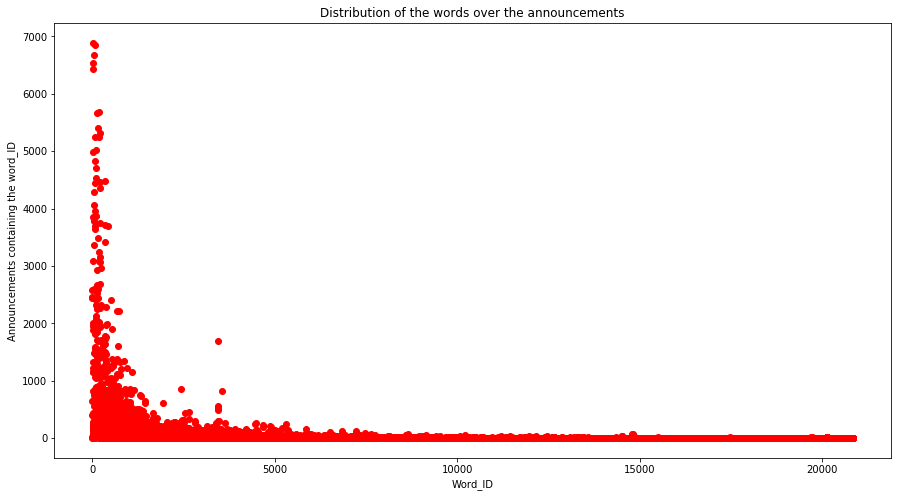

In [214]:
km.count_plot_words_occurrencies(TFIDF_dataframe)

As we can see, after the first words loaded into the vocabulary, the number of occurencies of the words start to decrease rapidly. This is normal, if we think that when we made the vocabulary (and also the TFIDF) the most common words have been stored into the dictionary with their associated Word_ID first. 

Hence, we can se that from ten thousand we have less

But, now the point is this: how influent are the words which compare in only one announcement? We've studied that with the TFIDF method the scope is about giving more value to less frequent words appearing in each 'document'. But in this case, we want to cluster similar documents, and how can we relate documents with features which compares only once? 

If we get a closer look to the final words of this dictionary, we can see how the files are di

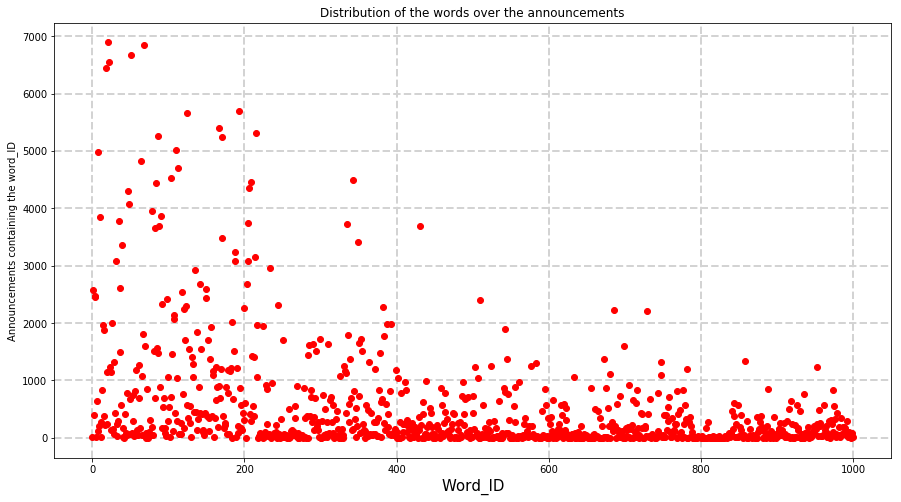

In [233]:
# look at the occurence of first 1000 words in all the dataframe
km.count_plot_words_occurrencies(TFIDF_dataframe.loc[:,0:1000], xstart=0, xend=1000+1)

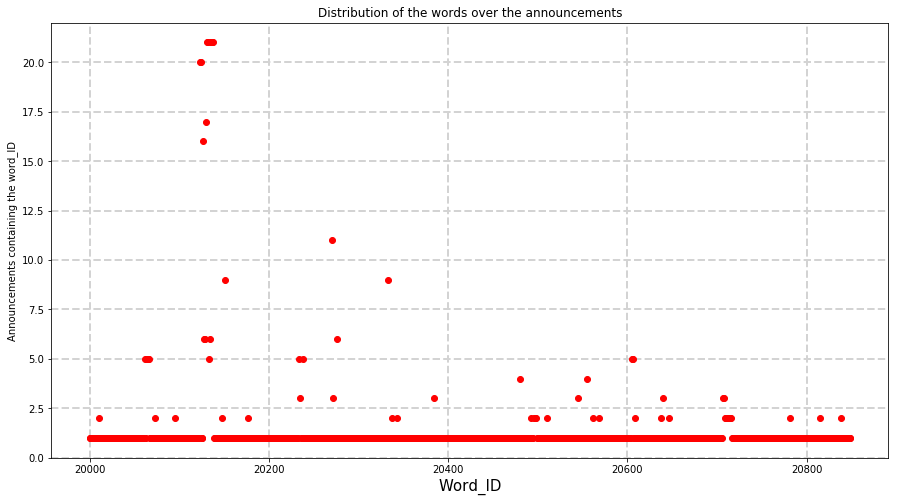

In [235]:
# closer look at the occurrence of the last 1000 words of the document 
km.count_plot_words_occurrencies(TFIDF_dataframe.loc[:,20000:],
                                 xstart=20000, xend=len(TFIDF_dataframe.iloc[0]))

As we can se, we have **a lot** of words that compare only **once** in all the documents. If we want to cluster, how can we compare something (the announcements) with features are not at all related? 

### Reduce the number of features (words)
Since we have seen that a lot words compares in only one document, and since we have to make a huge computation with k-means method (20850 dimensional vectors!) we decided to reduce the number of features.

Now, our task is to see how the elbow-method reacts at this reduction, knowing that it should works with a decreasing squared distance. We opted for different scenarios:


+ 0. Elbow method with 300  features  (removing words which compares in less than 5% of the total announcements)
+ 1. Elbow method with 500  features  (removing words which compares in less than 3% of the total announcements))
+ 2. Elbow method with 2000 features (removing words which compares in less than 1% of the total announcements))
+ 3. Elbow method with 5000 features (removing words which compares in less than 4 announcements)
+ 4. Elbow method with 6000 features (removing words which compares in less than 3 announcements)
+ 5. Elbow method with 10000 features (removing words which compares only in 1 announcement)

This elbow methods, computed over more or less 7 thousand of announcements, request much less computational work than the 'normal' one computed over 20 thousand of features.

For this series of Elbow methods we decided to **fix** our max number of clusters at 10. 

The reason is that it's preferable that the number of clusters between the two matrices is similar, also with the Jaccard similarity we will have at most 10*5 = 50 pairs of clusters, comparisons should be enough.

We drop out 20503 (over 20850) features which recurs in less than 369 announcements (over 7383)


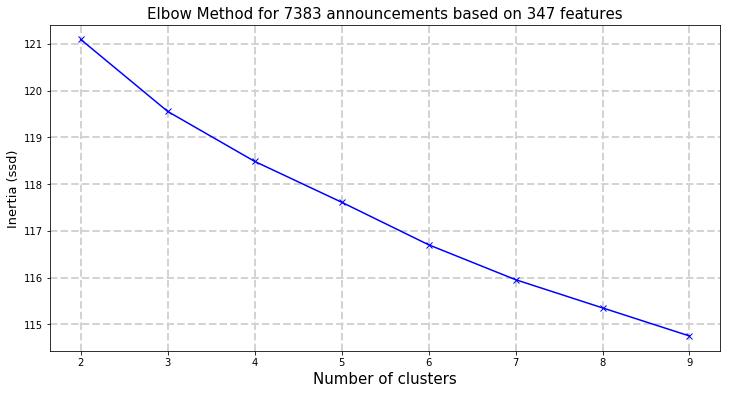

We drop out 20334 (over 20850) features which recurs in less than 221 announcements (over 7383)


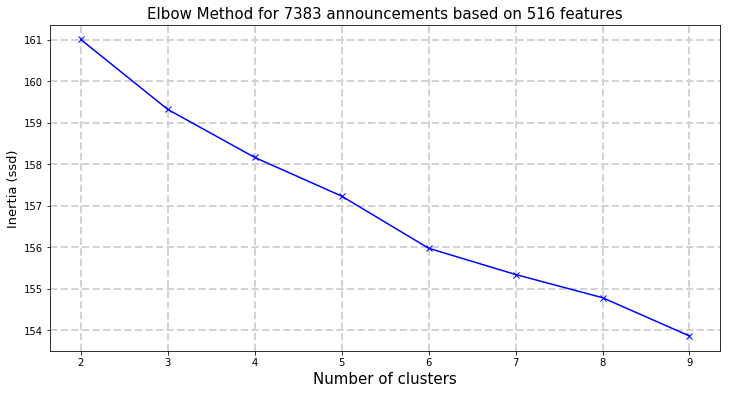

We drop out 19742 (over 20850) features which recurs in less than 73 announcements (over 7383)


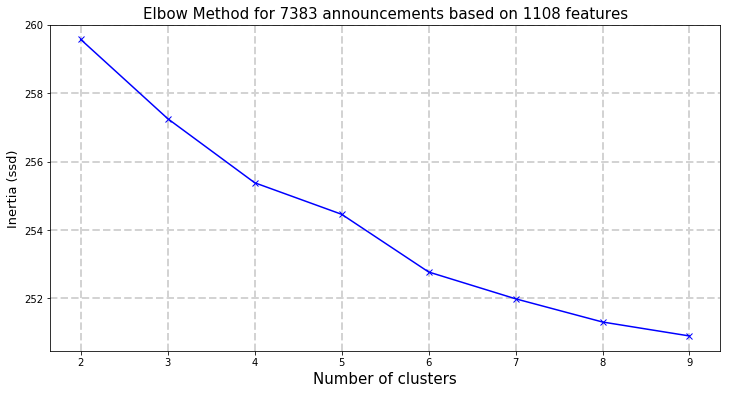

We drop out 14219 (over 20850) features which recurs in less than 4 announcements (over 7383)


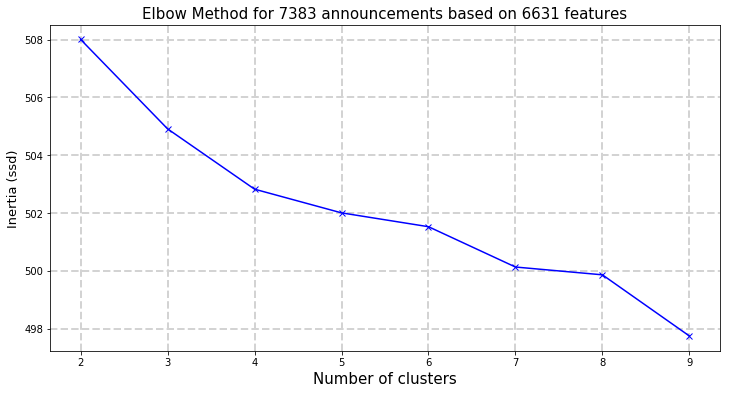

We drop out 10366 (over 20850) features which recurs in less than 2 announcements (over 7383)


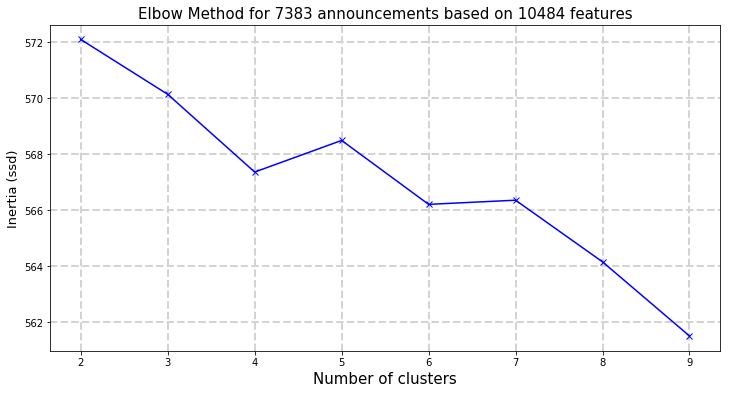

In [277]:
reload(km)
km.TFIDF_elbow_method_scenarios(TFIDF_dataframe)

As we can see, the results are getting worste and worste as the number of features increases. This is normal if we think that we're adding more constrains in our model, it's normal that its behavior should get worste (expecially if we have fixed the maximum number of clusters at 10).

#### For this reason, we decided to make our k-means method removing words that appears in less than 1% of all the announcements. Morehover, from the elbow method of the third graph above, we decided to pick 5 clusters, the same of the previous matrix, beacause we think the difference of the sum of squared distance is not so relevant and also we have the possibility to get homogeneous clusters among the two matrices.

In [280]:
# creating the new TFIDF removing words contained in only 1% of the announcements
new_TFIDF = km.clean_TFIDF(TFIDF_dataframe, threshold=len(TFIDF_dataframe)*0.01, messages=False)

We can see another time our new distribution of words over the announcements:

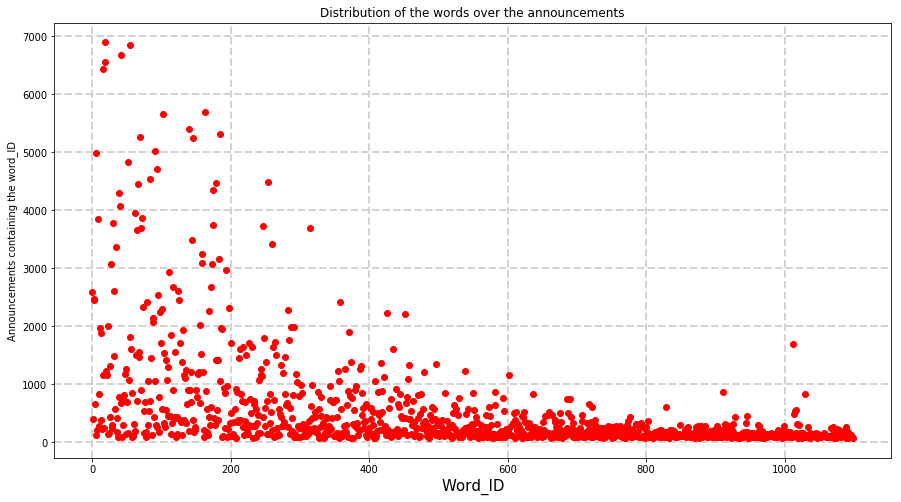

In [282]:
km.count_plot_words_occurrencies(new_TFIDF)

Notice that we could also remove words with a lot of occurencies (for instance words in more than 6000 announcements). We decided to not do this because first they're few and in any case they will have a low TFIDF value associated (TFIDF decrease with the presence of words in all the announcements).

Now we can compute the K-means algorithm

In [295]:
# kmeans++ with seed 1234 (for reproducibility).
model = KMeans(n_clusters=5, random_state=1234, init='k-means++')
model.fit(new_TFIDF)
clusters = model.predict(new_TFIDF)
df['TFIDF_cluster'] = clusters
df.head()

,title,price,locali,superficie,bagni,piano,description,description_stemmed,features_cluster,TFIDF_cluster
0,"Bilocale viale Italo Calvino, Fonte Ostiense, ...",225000.0,2,50.0,1,1.0,\n PAPILLO EUR ...,papill eur in eleg compless residenzial rifini...,0,2
1,"Quadrilocale via Alessandro Fleming, Fleming, ...",1350000.0,4,200.0,2,2.0,\n FLEMING - IN...,fleming in strad priv via alessandr fleming si...,2,0
2,"Attico / Mansarda largo Arturo Donaggio, Torre...",135000.0,2,60.0,1,5.0,\n Torrevecchia...,torrevecc adiacent larg artur donagg appart in...,4,3
3,"Bilocale viale delle Medaglie d'Oro 124, Medag...",249000.0,2,75.0,1,1.0,"\n Balduina, ad...",balduin adiacent piazz giovenal appart in vend...,0,3
4,"Bilocale via Savona, Villa Fiorelli, Roma",339000.0,2,70.0,1,3.0,\n In Via Savon...,in via savon una strad tranquill nel cuor di s...,0,0


## Jaccard similarity between two matrices clusters

Now, with the two group of clusters, the Jaccard-similarity is easy to compute.
Since we need only the two columns: features_cluster and TFIDF_cluster, we create a new dataframe for the jaccark similarity and we call it **Jdf**.

In [9]:
Jdf = pd.DataFrame()
Jdf = df[['features_cluster','TFIDF_cluster','description']]

Jdf.head()

NameError: name 'df' is not defined

In [14]:
import pandas as pd
Jdf = pd.read_csv('data/Jaccard_matrix.csv')
Jdf.head()

,Unnamed: 0,features_cluster,TFIDF_cluster,description
0,0,0,2,\n PAPILLO EUR ...
1,1,2,0,\n FLEMING - IN...
2,2,4,3,\n Torrevecchia...
3,3,0,3,"\n Balduina, ad..."
4,4,0,0,\n In Via Savon...


Now, we just create two dictionaries which represent the two groups of cluster.

Each dict will have has keys the number related to the cluster and has values all the documents of that cluster.

To do this we just make a short loop and we use *defaultdict* from *collections* module


Example with cluster one:

|keys(clusters)   |  values(list of announcements)  |
|-----------------|---------------------------------|
|    0            | [1,5,6,10]                      |      
|    1            | [2,4,100]                       |
|    2            | [3,123,123]                     |

In [15]:
from collections import defaultdict

features_clusters = defaultdict(list)
TFIDF_clusters = defaultdict(list)

for i in range(len(Jdf)):
    k1 = Jdf.iloc[i]['features_cluster']
    k2 = Jdf.iloc[i]['TFIDF_cluster']
    
    features_clusters[k1].append(i)
    TFIDF_clusters[k2].append(i)

Now, what we need is just compute the jaccard similarity. To do do that we use functions from jaccard modules

In [16]:
import Word_cloud_lib as wdcl

In [17]:
jaccard_similarities = wdcl.compute_jaccard_similarities(features_clusters, TFIDF_clusters)
jaccard_similarities[:3]

[(0, 0, 0.25208885265946607),
 (3, 2, 0.19129672897196262),
 (0, 2, 0.17927237912876975)]

Now we have three pairs of clusters {(0,0), (3,2), (0,2)}

Wee will make the wordcloud for each pair of clusters taking the descriptions.

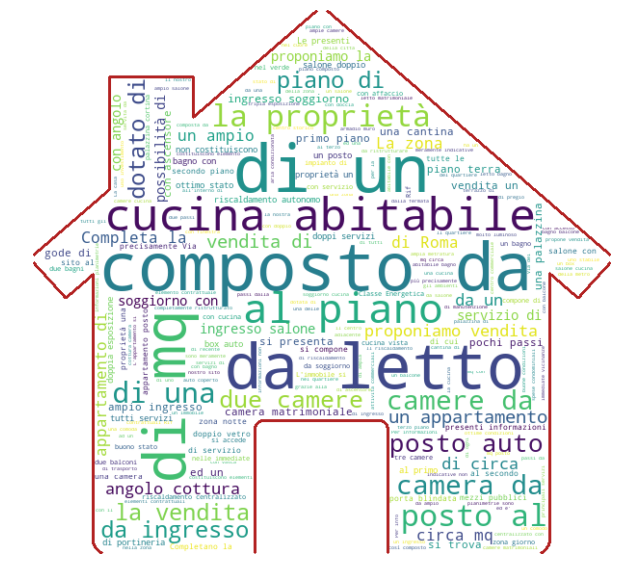

In [43]:
# Word cloud over first ranked couple of clusters (0, 0)
reload(wdcl)
wdcl.setWordcloud(Jdf, features_clusters[0], TFIDF_clusters[0])

2764992

                                PAPILLO EUR in elegante complesso residenziale rifinitissimo biloca


/Users/miguel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


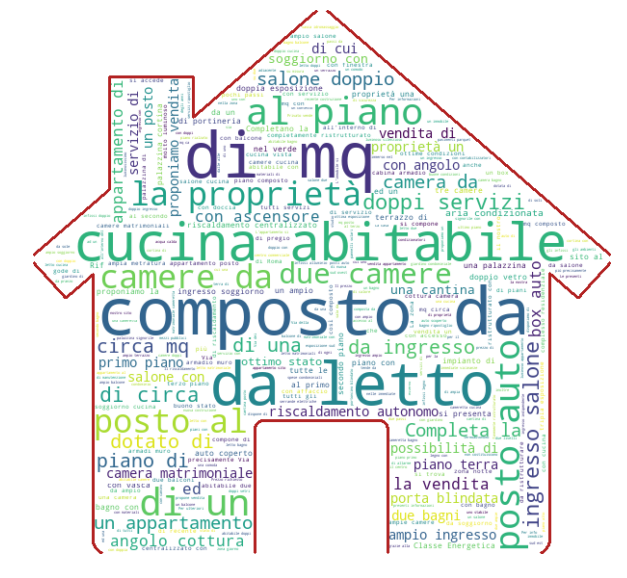

In [38]:
# Word cloud over first ranked couple of clusters (3, 2)
wdcl.setWordcloud(Jdf, features_clusters[3], TFIDF_clusters[2])

2764992

                                PAPILLO EUR in elegante complesso residenziale rifinitissimo biloca


/Users/miguel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


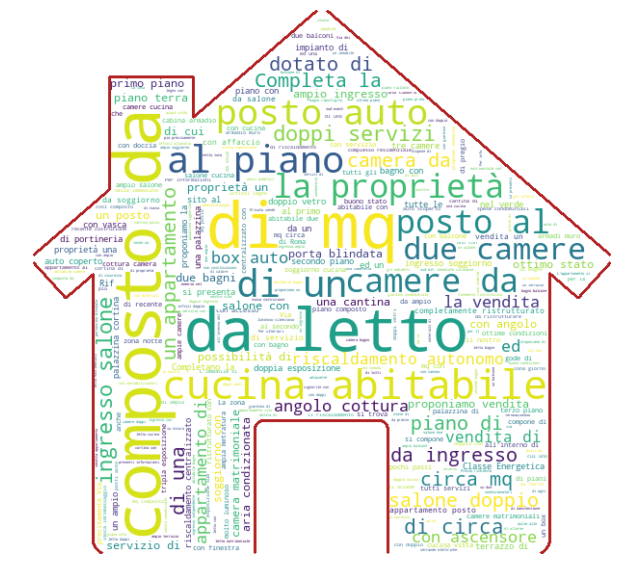

In [39]:
# Word cloud over first ranked couple of clusters (0, 3)
wdcl.setWordcloud(Jdf, features_clusters[3], TFIDF_clusters[2])

## Implement the K-means algorithm


In [58]:
reload(km)

<module 'k_means' from '/Users/miguel/Desktop/ADM_HW4/ADM-HW4/k_means.py'>

In [66]:
df_features.head()

,price,locali,superficie,bagni,piano
0,225000.0,2,50.0,1,1.0
1,1350000.0,4,200.0,2,2.0
2,135000.0,2,60.0,1,5.0
3,249000.0,2,75.0,1,1.0
4,339000.0,2,70.0,1,3.0


In [90]:
features_matrix = df_features.as_matrix()
features_matrix = np.matrix(features_matrix)
features_matrix

matrix([[2.25e+05, 2.00e+00, 5.00e+01, 1.00e+00, 1.00e+00],
        [1.35e+06, 4.00e+00, 2.00e+02, 2.00e+00, 2.00e+00],
        [1.35e+05, 2.00e+00, 6.00e+01, 1.00e+00, 5.00e+00],
        ...,
        [7.50e+05, 5.00e+00, 3.10e+02, 3.00e+00, 3.00e+00],
        [2.90e+05, 3.00e+00, 8.50e+01, 2.00e+00, 1.00e+00],
        [1.79e+05, 3.00e+00, 9.00e+01, 1.00e+00, 5.00e-01]])

In [91]:
k_means = km.KMeans(features_matrix, 5, 500)

In [83]:
pd.DataFrame.from_dict(k_means.clustering, orient='index').T

,0,1,2,3,4
0,29.0,4.0,0.0,1.0,12.0
1,87.0,11.0,2.0,9.0,17.0
2,110.0,13.0,3.0,21.0,22.0
3,122.0,15.0,5.0,28.0,31.0
4,198.0,20.0,6.0,30.0,33.0
5,200.0,24.0,7.0,36.0,38.0
6,257.0,25.0,8.0,41.0,40.0
7,277.0,27.0,10.0,46.0,43.0
8,558.0,35.0,14.0,53.0,50.0
9,1900.0,39.0,16.0,56.0,51.0


In [76]:
df['new_features_cluster'] = k_means.clustering

,title,price,locali,superficie,bagni,piano,description,description_stemmed,features_cluster
0,"Bilocale viale Italo Calvino, Fonte Ostiense, ...",225000.0,2,50.0,1,1.0,\n PAPILLO EUR ...,papill eur in eleg compless residenzial rifini...,0
1,"Quadrilocale via Alessandro Fleming, Fleming, ...",1350000.0,4,200.0,2,2.0,\n FLEMING - IN...,fleming in strad priv via alessandr fleming si...,2
2,"Attico / Mansarda largo Arturo Donaggio, Torre...",135000.0,2,60.0,1,5.0,\n Torrevecchia...,torrevecc adiacent larg artur donagg appart in...,4
3,"Bilocale viale delle Medaglie d'Oro 124, Medag...",249000.0,2,75.0,1,1.0,"\n Balduina, ad...",balduin adiacent piazz giovenal appart in vend...,0
4,"Bilocale via Savona, Villa Fiorelli, Roma",339000.0,2,70.0,1,3.0,\n In Via Savon...,in via savon una strad tranquill nel cuor di s...,0


In [72]:
df.head()

,title,price,locali,superficie,bagni,piano,description,description_stemmed
0,"Bilocale viale Italo Calvino, Fonte Ostiense, ...",225000.0,2,50.0,1,1.0,\n PAPILLO EUR ...,papill eur in eleg compless residenzial rifini...
1,"Quadrilocale via Alessandro Fleming, Fleming, ...",1350000.0,4,200.0,2,2.0,\n FLEMING - IN...,fleming in strad priv via alessandr fleming si...
2,"Attico / Mansarda largo Arturo Donaggio, Torre...",135000.0,2,60.0,1,5.0,\n Torrevecchia...,torrevecc adiacent larg artur donagg appart in...
3,"Bilocale viale delle Medaglie d'Oro 124, Medag...",249000.0,2,75.0,1,1.0,"\n Balduina, ad...",balduin adiacent piazz giovenal appart in vend...
4,"Bilocale via Savona, Villa Fiorelli, Roma",339000.0,2,70.0,1,3.0,\n In Via Savon...,in via savon una strad tranquill nel cuor di s...


# PARTE DUE

# Find the duplicates

***

After a power analysis, our strategy has been to face this task relying on a data structure that we already knew about and adapting it to our purposes. More specifically we implemented a **Bloom Filter-look-like** algorithm to fetch all the duplicate passwords stored in the txt file. This particular space-efficient data structure is used to test whether an element is a member of a set. The price we pay for efficiency is that it is probabilistic in nature meaning that there might be some **False Positive** results. False positive means, it might tell that given passwords are duplicate even if they actually aren't.


The important features of this data structure are:
+ Ability of representing a set with an arbitrarily **large** number of elements.
+ Adding an element never fails. However, the false positive rate increases steadily as elements are added until all bits in the array are set to 1, at which point all queries produce a positive result.
+ Never generates false negative result, i.e., telling you that a password does not have duplicates when it actually has.

### How does it work?

1. The algorithm is based on a huge **bit array** all set to zero. The bigger the bit array is, the less false positives will be detected.


2. When checking a password, the **hash function** converts the string to a very big number. In our case we assured that each character is mapped to a unique prime number computed starting by obtaining the **unicode** value of the character and finding the closest prime number to it that is not already stored. The final hash value is the multiplication of all the values of the characters contained in the password. The advantage of working with multiplication between **prime numbers** is to ensure greater uniqueness of the hash value of each password.


3. After computing the hashes k times with k different seeds (but always the same k different seeds for every other password), with the modulo operation (the rest of the division by the size of the bitarray) the result are three indexes i1 i2 i3.


4. If all three the indexes are already set to 1, it means that the password has already processed and checked so the password that we are checking rapresents a duplicate **or** a false positive, otherwise the indexes will be set to 1 meaning that the password is unique.

***

### Example

Suppose we want to check wether the password **'Orange'** is a duplicate or not. And suppose we have initialized the bitarray to **10** (the lenght of the bit array should be way more big but we choose 10 for explenation purposes and also the result values of the hash functions are not real, they are just for explanation purposes). We will have:

In [ ]:
pw1 = 'Orange'
size_bit_array = 10
    
#hash_it(pw1, 0) % size_bit_array = 3
#hash_it(pw1, 1) % size_bit_array = 7
#hash_it(pw1, 2) % size_bit_array = 4

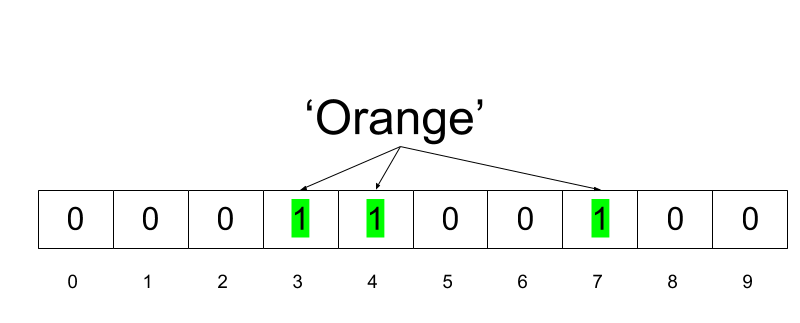

In [94]:
from IPython.display import Image
Image(filename='img/Orange.png')

When scanning other passwords of our set we will verify if another password already exists in the data structure simply repeating the steps again and checking if the indexes are already set to 1. In this case the password is a duplicate or a probable false positive.
So let's say now we check another word, **'Apple'**. We'll get:

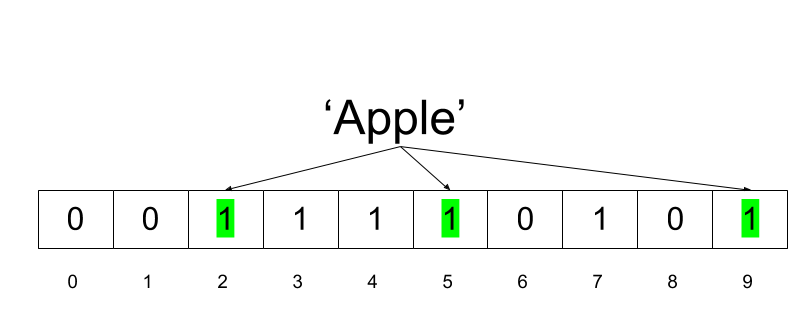

In [96]:
pw2 = 'Apple'
size_bit_array = 10

#hash_it(pw2, 0) % size_bit_array = 2
#hash_it(pw2, 1) % size_bit_array = 5
#hash_it(pw2, 2) % size_bit_array = 9



Image(filename='img/Apple.png')

But if we will check a password such as **'Gpple'**. There is high probability that the hash functions will generate the same values generated for **'Apple'**, obaining the same indexes. In this case the password will be considered a false positive.

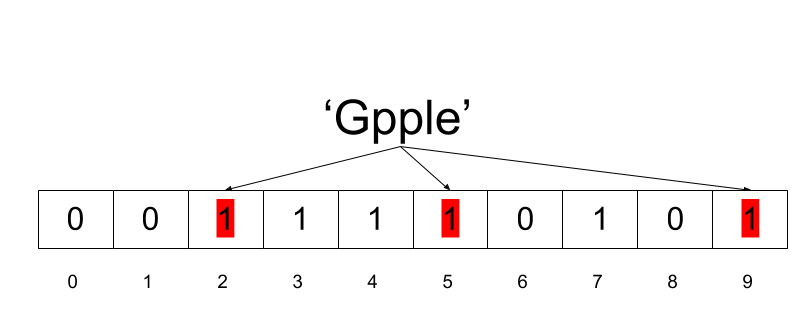

In [97]:
pw3 = 'Gpple'
size_bit_array = 10

#hash_it(pw3, 0) % size_bit_array = 2
#hash_it(pw3, 1) % size_bit_array = 5
#hash_it(pw3, 2) % size_bit_array = 9

Image(filename='img/Gpple.png')



So, because bits at calculated indices are already set by some other item, the data structure erroneously claim that 'Gpple' is present and generating a **false positive result**. We can control the probability of getting a false positive by controlling the size of the bit array. **More space means fewer false positives**. If we want to decrease probability of false positive result, we have to use more number of hash functions and larger bit array. This would add latency in addition of item and checking membership.

***


# Usage
The following chunks rapresent a possible usage of our implementation of the algorithm.

In [100]:
import pandas as pd
from SeekDuplicatesAlgorithm import FindDuplicates
import DuplicateModule as dpm
from importlib import reload

Loading the passwords set:

In [ ]:
passwords = dpm.loadPw()

In [ ]:
passwords[:5]

In [ ]:
Extracting single different characters that occur in all the set of passwords.

In [ ]:
l = dpm.extractChar(passwords)

In [ ]:
l[:5]

Creating a dictionary that assigns to each character detected before (considered as keys) to a unique prime number.

In [ ]:
wdict = dpm.createDict(l)

In [ ]:
The dictionary looks like this:

In [ ]:
dict_table = pd.DataFrame.from_dict(wdict, orient="index")
dict_table.index.names = ['Character']
dict_table[:10]

Checking whether the prime numbers inside the dictionary are actually unique. If checkDuplicateKeys() returns an **empty list**, it means that the values are **all unique**.

In [ ]:
dpm.checkDuplicateKeys(wdict)

Instatiating a FindDuplicates object from the class we implemented that has as parameters the size of the **bitarray**, the **list** of 3 prime numbers that will rapresent the seeds for the hash function, the list of all the **passwords** and the **dictionary** created before.

In [ ]:
dup = FindDuplicates(9000000000, [2, 3, 5], passwords, wdict)

## First case - "AABA" = "AAAB"

This is the actual usage of the whole algorithm. The two functions that are used are **check()** and **add()**, whenever the check function returns True, it means that the password in process is already stored in the bitarray and we incrementer a counter variable otherwise it means that the password has no duplicate so it's added to the structure. The result will be the counter variable tha rapresents the sum of all the duplicates and the false positive passwords.

In [ ]:
c = 0
for word in range(0, len(passwords)):
    if dup.check(passwords[word]):
        c += 1
    dup.add(passwords[word])
print('The overall number of duplicate strings and false positives are: {} '.format(c))

## Second case - "AABA" != "AAAB"

The usage of the class implemented changes just relatively to the **hash function**. Due to the fact that in this case we also want to consider the **order of the characters**, the hash function has been implemented concatenating the string value of each character and concatenating them to form a big string of number. The hash function will return at the end the integer value of this "big string".

### Example:

### dictionary = {'A' : 273 , 'B' : 599, 'C' : ......}
### hash value of 'AABA' = '273' + '599' + ''273' + '273' = <font color='red'> 273</font><font color='blue'>599</font><font color='red'>273273273</font>

### hash value of 'AAAB' = '599' + '273' + '273' + '599' = <font color='red'> 273273273273</font><font color='blue'>599</font>



In [ ]:
c = 0
for word in range(0, len(passwords)):
    if dup.check2(passwords[word]):
        c += 1
    dup.add2(passwords[word])
print('The overall number of duplicate strings and false positives considering the order of characters are: {} '.format(c))

In [99]:
c = 23
print('The overall number of duplicate strings and false positives are: {} '.format(c))

The overall number of duplicate strings and false positives are: 23 
